In [1]:
import numpy as np

In [2]:
def parity_dataset(n_features=12, n_samples=2000, seed=42):
    rng = np.random.default_rng(seed)
    X = rng.integers(0, 2, size=(n_samples, n_features))
    
    # etiqueta = paridad de características impares
    y = np.mod(np.sum(X[:, ::2], axis=1), 2)
    return X, y

X, y = parity_dataset()


In [ ]:
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from qiskit.primitives import StatevectorSampler
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit.circuit.library import ZZFeatureMap

def parity_dataset(n_features=8, n_samples=600, seed=42):  # ⚡ OPTIMIZADO
    rng = np.random.default_rng(seed)
    X = rng.integers(0, 2, size=(n_samples, n_features))
    y = np.mod(np.sum(X[:, ::2], axis=1), 2)
    return X, y

def normalize_kernel_matrix(K_train, K_test=None):
    diag_train = np.sqrt(np.diag(K_train))
    diag_train = np.where(diag_train == 0, 1e-10, diag_train)
    K_train_norm = K_train / np.outer(diag_train, diag_train)
    
    if K_test is None:
        return K_train_norm
    
    # Corrección para matriz rectangular
    if K_test.shape[0] == K_test.shape[1]:
        diag_test = np.sqrt(np.diag(K_test))
    else:
        # Para matriz rectangular (n_test, n_train), usar diagonal de K_test @ K_test.T
        diag_test = np.sqrt(np.diag(K_test @ K_test.T))
    
    diag_test = np.where(diag_test == 0, 1e-10, diag_test)
    K_test_norm = K_test / np.outer(diag_test, diag_train)
    return K_train_norm, K_test_norm

# Configuración optimizada
print("Configuración optimizada")

# Dataset más pequeño pero representativo
X, y = parity_dataset(n_features=8, n_samples=600)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0, stratify=y
)

print(f"\nDataset:")
print(f"   Train: {len(X_train)} samples")
print(f"   Test:  {len(X_test)} samples")
print(f"   Features: {X.shape[1]}")

# Feature map optimizado
feature_map = ZZFeatureMap(
    feature_dimension=X.shape[1],
    reps=2,
    entanglement='linear'
)

sampler = StatevectorSampler()
fidelity_instance = ComputeUncompute(sampler=sampler)
quantum_kernel = FidelityQuantumKernel(
    feature_map=feature_map,
    fidelity=fidelity_instance
)

print("Kernel Cuántico")

print("\nEvaluación del kernel de entrenamiento")
print(f"   Calculando {len(X_train)}×{len(X_train)} = {len(X_train)**2:,} fidelidades")
start_total = time.time()
start = time.time()

K_train_raw = quantum_kernel.evaluate(X_train)

t1 = time.time() - start
print(f" Completado en {t1:.1f}s ({t1/60:.2f} min)")
print(f" Velocidad: {len(X_train)**2/t1:.0f} fidelidades/seg")

print("\nEvaluación del kernel de test")
print(f" Calculando {len(X_test)}×{len(X_train)} = {len(X_test)*len(X_train):,} fidelidades")
start = time.time()

K_test_raw = quantum_kernel.evaluate(X_test, X_train)

t2 = time.time() - start
print(f" Completado en {t2:.1f}s ({t2/60:.2f} min)")
print(f" Velocidad: {len(X_test)*len(X_train)/t2:.0f} fidelidades/seg")

total_quantum_time = time.time() - start_total
print(f"\nTiempo total quantum kernel: {total_quantum_time/60:.2f} minutos")

# Normalización
print("\nNormalizando matrices de kernel")
K_train_q, K_test_q = normalize_kernel_matrix(K_train_raw, K_test_raw)

# SVM cuántico
print("Entrenando SVM con kernel cuántico")
svc_q = SVC(kernel="precomputed")
svc_q.fit(K_train_q, y_train)
preds_q = svc_q.predict(K_test_q)
acc_q = accuracy_score(y_test, preds_q)
print(f" Accuracy: {acc_q:.3f}")

# Kernels clásicos
print("Kernels clásicos")

print("\nRBF Kernel")
svc_rbf = SVC(kernel="rbf", gamma="scale")
svc_rbf.fit(X_train, y_train)
acc_rbf = accuracy_score(y_test, svc_rbf.predict(X_test))
print(f" Accuracy: {acc_rbf:.3f}")

print("Polynomial Kernel (degree=3)")
svc_poly = SVC(kernel="poly", degree=3)
svc_poly.fit(X_train, y_train)
acc_poly = accuracy_score(y_test, svc_poly.predict(X_test))
print(f" Accuracy: {acc_poly:.3f}")

print("Linear Kernel")
svc_lin = SVC(kernel="linear")
svc_lin.fit(X_train, y_train)
acc_lin = accuracy_score(y_test, svc_lin.predict(X_test))
print(f" Accuracy: {acc_lin:.3f}")

# Resultados finales
print("\nResultados finales")
print(f"\n{'Modelo':<30} {'Accuracy':>10} {'Tiempo':>12}")
print(f"{'Quantum Kernel (ZZFeatureMap)':<30} {acc_q:>10.3f} {total_quantum_time/60:>10.2f} min")
print(f"{'RBF Kernel':<30} {acc_rbf:>10.3f} {'<1 seg':>12}")
print(f"{'Polynomial Kernel (deg=3)':<30} {acc_poly:>10.3f} {'<1 seg':>12}")
print(f"{'Linear Kernel':<30} {acc_lin:>10.3f} {'<1 seg':>12}")

# Análisis
print("\nANÁLISIS:")
if acc_q > max(acc_rbf, acc_poly, acc_lin):
    diff = acc_q - max(acc_rbf, acc_poly, acc_lin)
    print(f" Quantum kernel supera a clásicos por {diff:.3f}")
else:
    best_classical = max(acc_rbf, acc_poly, acc_lin)
    print(f" Mejor kernel clásico: {best_classical:.3f} vs Quantum: {acc_q:.3f}")
    
print(f" Costo computacional: {total_quantum_time/60:.1f}x más lento")

Configuración optimizada

Dataset:
   Train: 450 samples
   Test:  150 samples
   Features: 8
Kernel Cuántico

Evaluación del kernel de entrenamiento
   Calculando 450×450 = 202,500 fidelidades
 Completado en 2222.5s (37.04 min)
 Velocidad: 91 fidelidades/seg

Evaluación del kernel de test
 Calculando 150×450 = 67,500 fidelidades
 Completado en 1472.2s (24.54 min)
 Velocidad: 46 fidelidades/seg

Tiempo total quantum kernel: 61.58 minutos

Normalizando matrices de kernel
Entrenando SVM con kernel cuántico
 Accuracy: 0.940
🖥️  Kernels clásicos

RBF Kernel
 Accuracy: 0.693
Polynomial Kernel (degree=3)
 Accuracy: 0.573
Linear Kernel
 Accuracy: 0.487

Resultados finales

Modelo                           Accuracy       Tiempo
Quantum Kernel (ZZFeatureMap)       0.940      61.58 min
RBF Kernel                          0.693       <1 seg
Polynomial Kernel (deg=3)           0.573       <1 seg
Linear Kernel                       0.487       <1 seg

ANÁLISIS:
 Quantum kernel supera a clásicos por

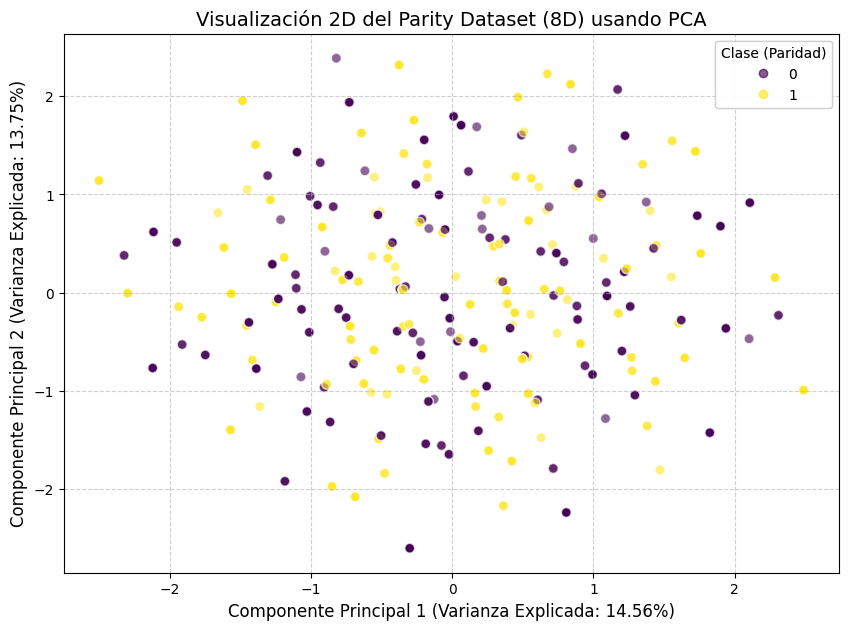

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Definición del Dataset
def parity_dataset(n_features=8, n_samples=600, seed=42):
    rng = np.random.default_rng(seed)
    X = rng.integers(0, 2, size=(n_samples, n_features))
    y = np.mod(np.sum(X[:, ::2], axis=1), 2)
    return X, y

# 2. Generar el Dataset
n_features = 8
n_samples = 600
X, y = parity_dataset(n_features=n_features, n_samples=n_samples)

# 3. Preparación y Aplicación de PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 4. Visualización con Matplotlib
plt.figure(figsize=(10, 7))

scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=y,
    cmap='viridis',
    alpha=0.6,
    edgecolors='w',
    s=50
)

# Añadir títulos y etiquetas
plt.title(f'Visualización 2D del Parity Dataset ({n_features}D) usando PCA', fontsize=14)
plt.xlabel(f'Componente Principal 1 (Varianza Explicada: {pca.explained_variance_ratio_[0]*100:.2f}%)', fontsize=12)
plt.ylabel(f'Componente Principal 2 (Varianza Explicada: {pca.explained_variance_ratio_[1]*100:.2f}%)', fontsize=12)

# Crear una leyenda
legend1 = plt.legend(*scatter.legend_elements(), title="Clase (Paridad)", loc="upper right")
plt.gca().add_artist(legend1)

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

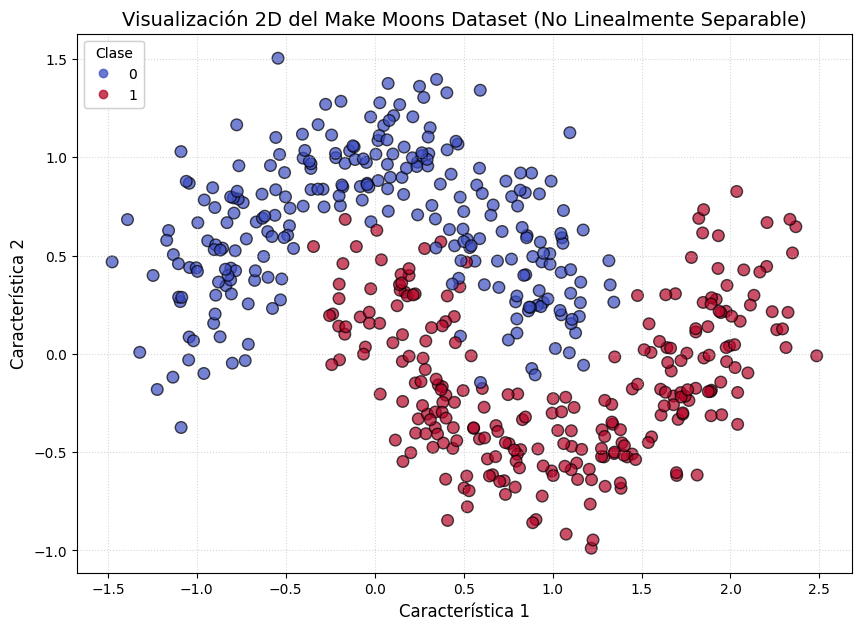

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# 1. Generar el Dataset Make Moons
X, y = datasets.make_moons(n_samples=500, noise=0.2, random_state=42)

# 2. Visualización con Matplotlib
plt.figure(figsize=(10, 7))

scatter = plt.scatter(
    X[:, 0],
    X[:, 1],
    c=y,
    cmap='coolwarm',
    alpha=0.7, 
    edgecolors='k',
    s=70
)

# Títulos y etiquetas
plt.title('Visualización 2D del Make Moons Dataset (No Linealmente Separable)', fontsize=14)
plt.xlabel('Característica 1', fontsize=12)
plt.ylabel('Característica 2', fontsize=12)

# Crear una leyenda
legend1 = plt.legend(*scatter.legend_elements(), title="Clase", loc="upper left")
plt.gca().add_artist(legend1)

plt.grid(True, linestyle=':', alpha=0.5)
plt.show()